In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [2]:
import LoadDataset

In [3]:
IMG_WIDTH = 32 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 3 # RGB files

In [4]:
DATSET_SIZE =  20000
NUM_LABELS = 2

In [5]:
data = LoadDataset.getFixedNumDigistsDataSet(DATSET_SIZE, NUM_LABELS)
imgs = data[1]
labels = data[2]
numPoints = data[0]

In [6]:
print (numPoints)
print (labels.shape)
print (imgs.shape)

18130
(18130, 2)
(18130, 32, 32, 3)


[4 8]


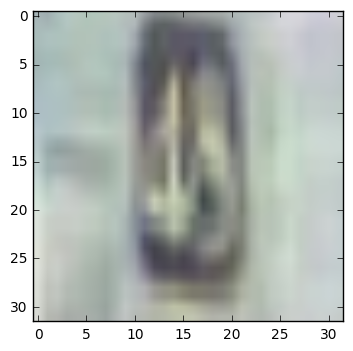

In [7]:
print (labels[10])
plt.imshow(imgs[10]) #, cmap='gray')

In [8]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense.ravel()]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [9]:
# Get the dataset
X = imgs.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labels

In [10]:
# Generate validation set
ratio = 0.9 # Train/Test set
randIdx = np.random.random(numPoints) <= ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 11) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 11) for idx in range(Y_test.shape[1])] 
del X, Y # release some space

In [11]:
print (X_train.shape)

(16276, 32, 32, 3)


In [ ]:
print (np.mean(Y_train[1], axis = 0))

[ 0.11102236  0.11249693  0.10389531  0.1017449   0.09682969  0.10334234
  0.09080855  0.09781273  0.092406    0.08964119  0.        ]


In [ ]:
# Building convolutional network

with tf.Graph().as_default():
    input = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input')

    network = conv_2d(input, 32, 11, activation='relu', regularizer="L2")
    network = conv_2d(input, 32, 5, activation='relu', regularizer="L2")
    network = max_pool_2d(network, 2)
    network = local_response_normalization(network)
    network = conv_2d(network, 64, 5, activation='relu', regularizer="L2")
    network = conv_2d(input, 64, 1, activation='relu', regularizer="L2")
    network = max_pool_2d(network, 2)
    network = local_response_normalization(network)
    network = conv_2d(network, 128, 5, activation='relu', regularizer="L2")
    network = conv_2d(input, 128, 1, activation='relu', regularizer="L2")
    network = local_response_normalization(network)

    # Training heads
    allHeads = []
    for idx in range(NUM_LABELS):
        fc = fully_connected(network, 128, activation='tanh')
        fc = fully_connected(fc, 128, activation='tanh')
        #fc = dropout(fc, 0.8)
        #fc = fully_connected(fc, 1024, activation='tanh')
        #fc = dropout(fc, 0.8)
        softmax = fully_connected(fc, 11, activation='softmax')
        networkOut = regression(softmax, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target' + str(idx))
        allHeads.append(networkOut)

    network = tflearn.merge(allHeads, mode='elemwise_sum')
    model = tflearn.DNN(network, tensorboard_verbose=1)
    feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(NUM_LABELS)}
    feedTestList =  [Y_test[i] for i in range(NUM_LABELS)]
    model.fit({'input': X_train}, feedTrainDict, 
              validation_set= (X_test, feedTestList), n_epoch=5, snapshot_step=100, show_metric=True, run_id='convnet_svhn')
#    model.fit({'input': X_train}, feedTrainDict, n_epoch=3, show_metric=True, run_id='convnet_mnist')

#    print (model.evaluate(X_test,feedTestList))

Training Step: 39  | total loss: 4.49266
| Adam_0 | epoch: 000 | loss: 2.13895 - acc: 0.2394 -- iter: 02496/16276
| Adam_1 | epoch: 000 | loss: 2.35371 - acc: 0.1100 -- iter: 02496/16276
